# Medium Dense ANN

Added dropout layers to medium size model. Does not overfit as much.  On par with the simple model.

```
model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(df_train.columns)]),
        layers.Dropout(0.25, seed=123),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25, seed=123),
        layers.Dense(1, activation='sigmoid')
    ])
```

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from binaryclassifier.analyzer import Analyzer
from data.utils import prepare_titanic, encode_features

print('Tensorflow:', tf.__version__)

Tensorflow: 2.1.0


In [2]:
class EpochDots(keras.callbacks.Callback):
    """A simple callback that prints a "." every epoch, with occasional reports.
    
    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """

    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='')

In [3]:
df_train, df_test, y_train, y_test = prepare_titanic()

# Encode columns as features
df_train = encode_features(df_train)
df_test = encode_features(df_test)

# Normalize features using training data
norm_df = df_train.describe().transpose()

def norm(x, norm_df):
    return (x - norm_df['mean']) / norm_df['std']

df_train_sc = norm(df_train, norm_df)
df_test_sc = norm(df_test, norm_df)

Download or read from disk.
Convert to pandas.DataFrame
Partition into Train and Test
    Test size = 0.3
    random_state = 123


In [4]:
df_train.shape

(916, 11)

In [5]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(df_train.columns)]),
        layers.Dropout(0.25, seed=123),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25, seed=123),
        layers.Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    
    model.compile(optimizer=optimizer,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=METRICS
                 )
    
    return model

In [6]:
model = build_model()

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Test an example batch (on untrained params)
example_batch = df_train_sc[:10]
example_result = model.predict(example_batch)
example_result

array([[0.42993072],
       [0.5652256 ],
       [0.32224548],
       [0.54465145],
       [0.2895528 ],
       [0.5151614 ],
       [0.49821976],
       [0.43568775],
       [0.33232534],
       [0.4241394 ]], dtype=float32)

# Train the Model

In [9]:
EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(
    df_train_sc, y_train, epochs=EPOCHS, 
    validation_split=0.2, verbose=0,
    callbacks=[early_stop, 
               EpochDots()]
)


Epoch: 0, accuracy:0.6694,  auc:0.6585,  fn:187.0000,  fp:55.0000,  loss:0.6274,  precision:0.5956,  recall:0.3022,  tn:409.0000,  tp:81.0000,  val_accuracy:0.7065,  val_auc:0.7584,  val_fn:46.0000,  val_fp:8.0000,  val_loss:0.5848,  val_precision:0.7419,  val_recall:0.3333,  val_tn:107.0000,  val_tp:23.0000,  
............................................................................

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['epoch'] = hist['epoch'] + 1

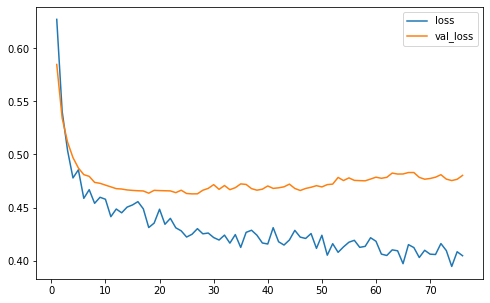

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(hist['epoch'], hist['loss'], label='loss')
ax.plot(hist['epoch'], hist['val_loss'], label='val_loss')
plt.legend()

In [12]:
scores = model.predict(df_test_sc).ravel()
preds = np.where(scores > 0.5, 1, 0)

print('AUC:       {:6.4f}'.format(metrics.roc_auc_score(y_test, scores)))
print('Accuracy:  {:6.4f}'.format(metrics.accuracy_score(y_test, preds)))
print('Recall:    {:6.4f}'.format(metrics.recall_score(y_test, preds)))
print('Precision: {:6.4f}'.format(metrics.precision_score(y_test, preds)))
print('F1 Score:  {:6.4f}'.format(metrics.f1_score(y_test, preds)))

AUC:       0.8570
Accuracy:  0.7939
Recall:    0.6074
Precision: 0.8534
F1 Score:  0.7097


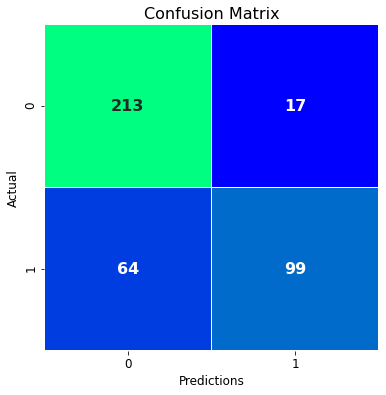

In [13]:
analyzer = Analyzer(preds=preds, scores=scores, y_true=y_test.reset_index(drop=True))
analyzer.plot_confusion_matrix()

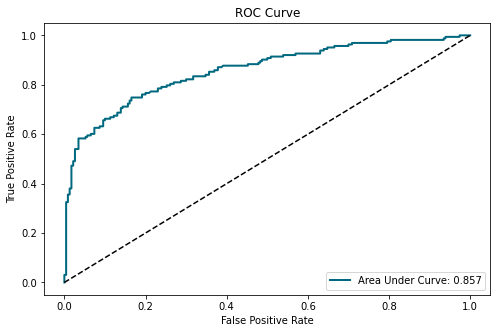

In [14]:
analyzer.plot_roc_curve()

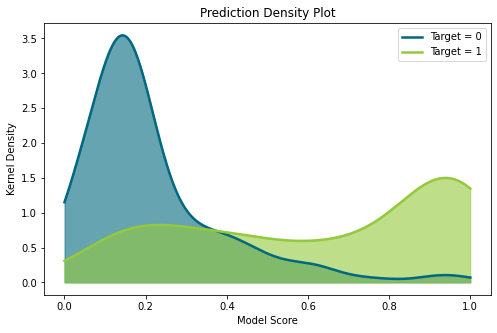

In [15]:
analyzer.plot_prediction_density()

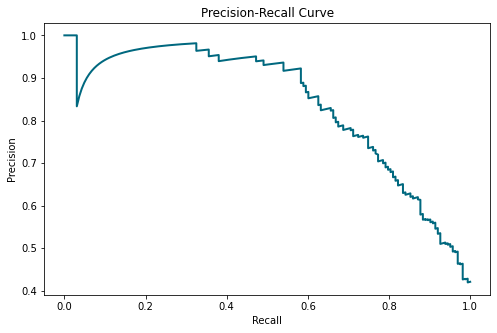

In [16]:
analyzer.plot_precision_recall()

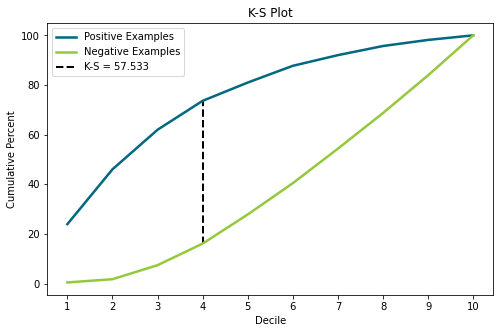

In [17]:
analyzer.plot_ks()

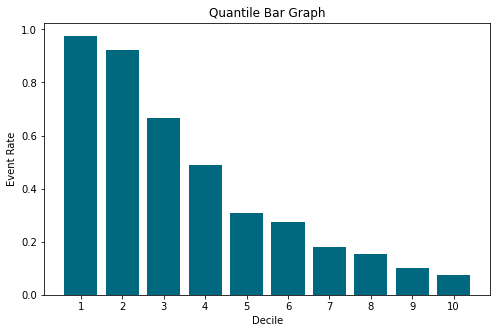

In [18]:
analyzer.plot_quantiles()